[Aggarwala and Voight 2016](https://github.com/quinlan-lab/constraint-tools/blob/main/literature/germline/aggarwala%20and%20voight%202016/ng.3511.pdf) used 1000 genomes to compute the probabilities 
of all classes of nucleotide substitution in the intergenic noncoding genome (their Fig 2):


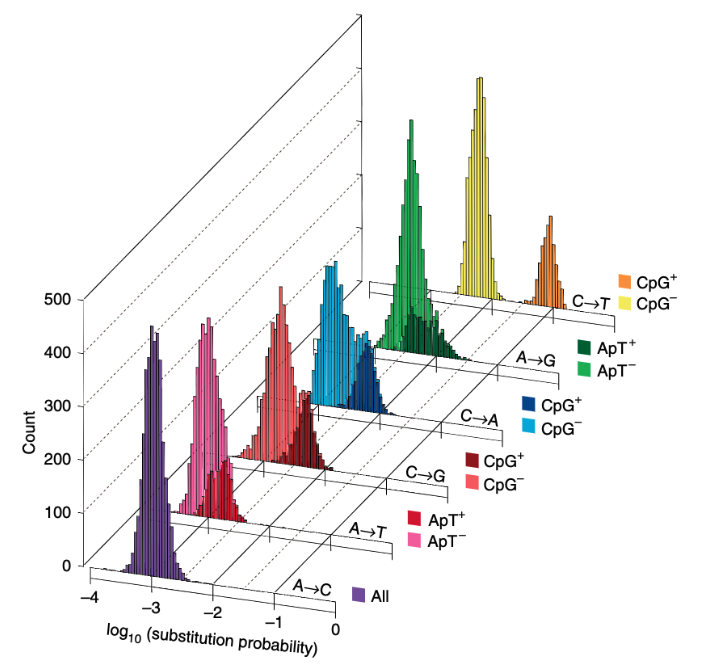

In [4]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image
Image(filename='AggarwalaVoightFig2.png', width=1000)

We may do a similar analysis for the ~70,000 individuals in gnomad version 3: 

In [2]:
import json 
import numpy as np 
import matplotlib.pyplot as plt 

import sys
sys.path.append('/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/utilities')

from kmer import CpG, ApT, not_CpG, not_ApT, middle_base

def kmer_size(kmer_probabilities): 
  for kmer in kmer_probabilities.keys(): 
    return len(kmer)

def get_bar_width(bins): 
  return bins[1] - bins[0]

def get_bin_centers(bins): 
  return (bins[:-1] + bins[1:])/2

def get_kmer_probabilities(): 
  model = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools/dist/model-germline-grch38.json'
  with open(model, 'r') as fh:
    return json.load(fh)['kmerProbabilities']

def get_logprobabilities_counts(ref_allele, alt_state, kmer_is_positive): 
  kmer_probabilities = get_kmer_probabilities() 
  
  log_probabilities_positive_class = []
  log_probabilities_negative_class = []
  for kmer, probabilities in kmer_probabilities.items():         
    if middle_base(kmer) == ref_allele:
      l = log_probabilities_positive_class if kmer_is_positive(kmer) else log_probabilities_negative_class
      l.append(np.log10(probabilities[alt_state]))

  logbins = np.linspace(-4, 0 , 100)
  counts_positive_class, logbins_positive_class = np.histogram(log_probabilities_positive_class, bins=logbins)
  counts_negative_class, logbins_negative_class = np.histogram(log_probabilities_negative_class, bins=logbins)
  return ( 
    get_bin_centers(logbins_positive_class), 
    counts_positive_class,
    get_bin_centers(logbins_negative_class), 
    counts_negative_class
  ) 

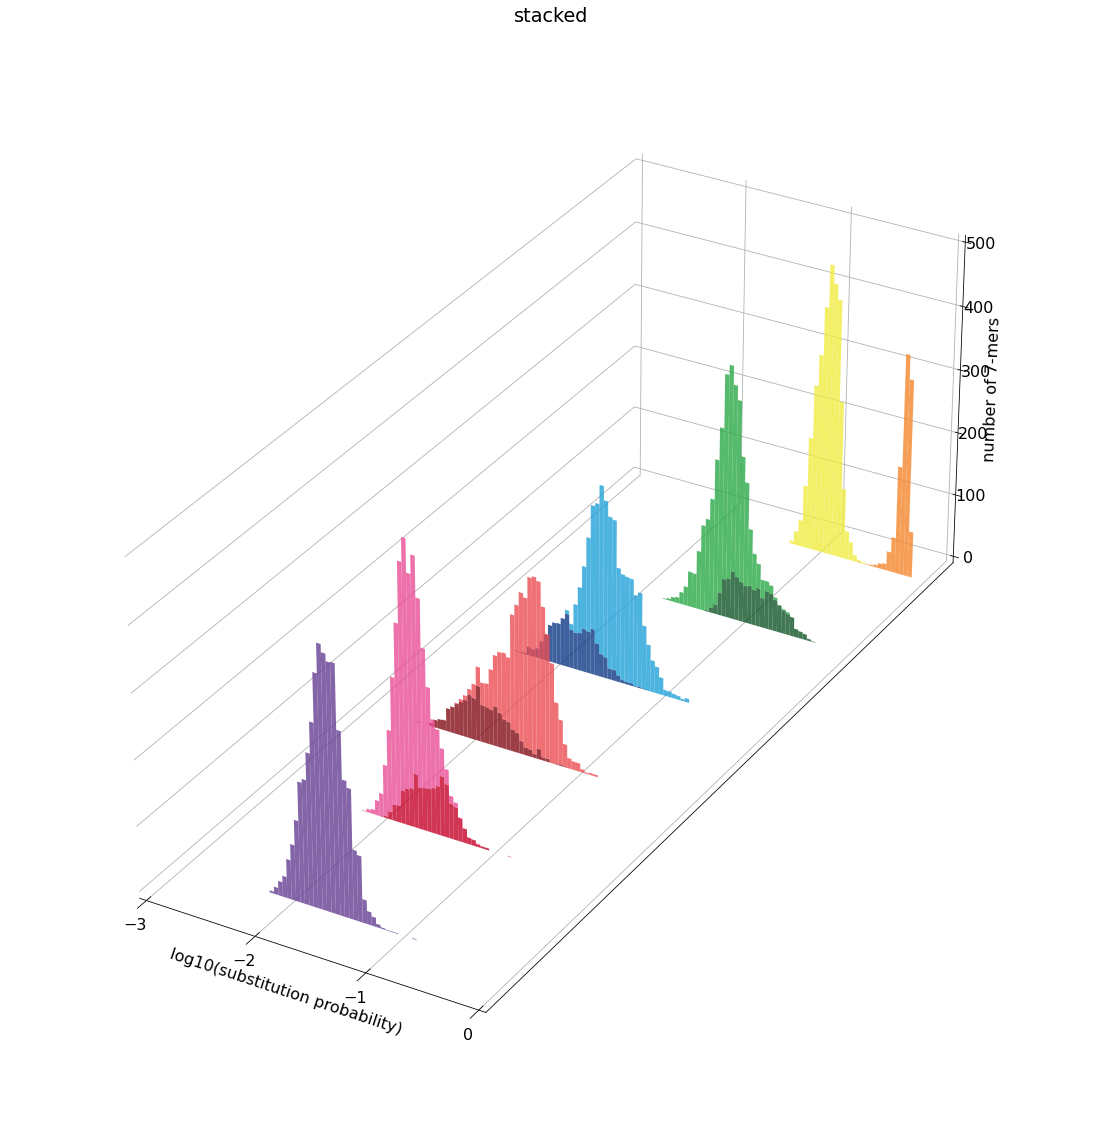

In [3]:
def plot_substitution_probabilities():
  # https://matplotlib.org/stable/gallery/mplot3d/bars3d.html#sphx-glr-gallery-mplot3d-bars3d-py
  # https://stackoverflow.com/questions/35210337/can-i-plot-several-histograms-in-3d

  plt.rcParams.update({'font.size': 16})

  fig = plt.figure()
  fig.set_size_inches(40, 20)
  ax = fig.add_subplot(projection='3d')

  # first element in tuple corresponds to positive class
  # second element in tuple corresponds to negative class
  colors = [
    ('#F4862C', '#F0EB41'),
    ('#115528', '#2AA946'), 
    ('#0E3985', '#21A0D8'), 
    ('#840E17', '#EC4D54'), 
    ('#C50328', '#E94D96'), 
    ('#663F93', None)
  ]
  yticks = [5, 4, 3, 2, 1, 0]
  ref_alleles__alt_states__kmer_is_positive_functions = [
    ('C', '{T}', CpG),
    ('A', '{G}', ApT),
    ('C', '{A}', CpG),
    ('C', '{G}', CpG),
    ('A', '{T}', ApT),
    ('A', '{C}', lambda kmer: True)  
  ]

  for (
    color, 
    ytick, 
    ref_allele__alt_state__kmer_is_positive_function
  ) in zip(
    colors, 
    yticks,
    ref_alleles__alt_states__kmer_is_positive_functions
  ):
    ref_allele, alt_state, kmer_is_positive = ref_allele__alt_state__kmer_is_positive_function
    (
      log_probabilities_positive_class, 
      counts_positive_class,
      log_probabilities_negative_class, 
      counts_negative_class
    ) = get_logprobabilities_counts(ref_allele, alt_state, kmer_is_positive)
    color_positive_class, color_negative_class = color
    bar_width = get_bar_width(log_probabilities_positive_class)
    ax.bar(
      log_probabilities_positive_class, 
      counts_positive_class, 
      width=bar_width, 
      zs=ytick, 
      zdir='y', 
      color=color_positive_class, 
      edgecolor=None, 
      alpha=0.8
    )
    ax.bar(
      log_probabilities_negative_class, 
      counts_negative_class, 
      width=bar_width, 
      zs=ytick, 
      zdir='y', 
      color=color_negative_class, 
      edgecolor=None, 
      alpha=0.8, 
      bottom=counts_positive_class
    )

  ax.set_xlabel('log10(substitution probability)')
  ax.set_ylabel('')
  ax.set_zlabel('number of {}-mers'.format(kmer_size(get_kmer_probabilities())))

  ax.set_xticks([-4, -3, -2, -1, 0])
  ax.set_yticks([])

  ax.set_xlim([-3, 0])
  ax.set_zlim([0, 500])

  ax.set_title('stacked')

  ax.set_box_aspect((1, 2.5, 1))

  white_rgba = (1.0, 1.0, 1.0, 1.0)
  ax.w_xaxis.set_pane_color(white_rgba)
  ax.w_yaxis.set_pane_color(white_rgba)
  ax.w_zaxis.set_pane_color(white_rgba)

plot_substitution_probabilities()

Notice that the x-axes in the two plots appear to be shifted relative to one another by about a factor of 10, which is consistent with the fact that size of the cohorts in both cases differ by about a factor of 10. 

The relative trends appear to be the same in both plots, apart from C > G and C > A, in which cases the CpG+ distribution appear to be on opposite sides of the CpG- distribution. Why might this be? 

One possible explanation relates to the fact that Aggarwala et al report maximum-a-posteriori estimators of substitution probabilies, whereas we compute only maximum-likelihood estimators. The procedure they use is described [here](https://photos.app.goo.gl/znSMF7AwUs7GWCXR7). Since the posterior estimators make use of substitution counts in coding regions, it is possible that coding-region specific trends propagate through to the posterior estimates in non-coding regions, explaining the discrepancy between Aggarwala et al's results and ours. 

